In [225]:
# Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

!pip install cplex
import cplex




In [226]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
   x_optimal = x_init
   cash_optimal = cash_init
   return x_optimal, cash_optimal

In [227]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    port_value = np.dot(cur_prices,x_init) + cash_init

    x_optimal = np.floor(np.full(20,1/20)*port_value / cur_prices)

    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005

    cash_optimal = port_value - np.dot(cur_prices,x_optimal) - tran_cost
        
    return x_optimal, cash_optimal

In [228]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
   port_value = np.dot(cur_prices,x_init) + cash_init

   n = 20
   cpx = cplex.Cplex()
   cpx.objective.set_sense(cpx.objective.sense.minimize)

   c  = [0.0] * n
   lb = [0.0] * n
   ub = [1.0] * n

   A = []
   for k in range(n):
    A.append([[0,1],[1.0, 0]])
   
   var_names = ["w_%s" % i for i in range(1,n+1)]
   cpx.linear_constraints.add(rhs=[1.0,0],senses='EG')
   cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
   Qmat = [[list(range(n)),list(2*Q[k,:])] for k in range(n)]
   cpx.objective.set_quadratic(Qmat)
   cpx.parameters.threads.set(4) 
   cpx.set_results_stream(None)
   cpx.set_warning_stream(None)
   cpx.solve()
   
   w = np.array(cpx.solution.get_values())
   
   x_optimal = np.floor(w*port_value/cur_prices)
    
   tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005

   cash_optimal = port_value - np.dot(cur_prices,x_optimal) - tran_cost


   return x_optimal, cash_optimal


In [229]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    port_value = np.dot(cur_prices,x_init) + cash_init

    n = 21
    r_rf = 0.025
    day_rf = 0.025 / 252

    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    c = [0]*n
    lb = [0]*n
    ub = [np.inf]*n

    Q = np.append(Q,np.zeros((20,1)), axis=1)
    zero_arr = np.zeros((21))
    Q = np.vstack([Q,zero_arr])

    diff = mu - day_rf * np.ones(20)

    A = []
    for k in range(n-1):
        A.append([[0,1],[diff[k],1.0]])
    A.append([[0,1],[0,-1.0]])

    var_names = ['y_%s'% i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EE')
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)
    Qmat = [[list(range(n)),list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()

    ans = np.array(cpx.solution.get_values())
    
    w = ans[0:20]/ans[20]

    x_optimal = np.floor(w*port_value/cur_prices)
    
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005

    cash_optimal = port_value - np.dot(cur_prices,x_optimal) - tran_cost
    
    return x_optimal, cash_optimal

In [230]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)



In [231]:
# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value




Initial portfolio value = $ 1000012.93



In [232]:
# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025


In [233]:
# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']
# N_strat = 1 
N_strat = len(strategy_functions)
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

In [234]:
from pandas.core.dtypes.cast import construct_1d_object_array_from_listlike
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      if cash[strategy, period-1] < 0:
        port_value = np.dot(cur_prices, curr_positions) + curr_cash
        ratio = x[strategy, period-1]/sum(x[strategy, period-1])
        exce_cash = abs(cash[strategy, period-1])*ratio
        exce_x = np.ceil(exce_cash/cur_prices)
        x[strategy, period-1] = x[strategy, period-1] - exce_x
        new_tran_cost = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
        cash[strategy, period-1] = port_value - np.dot(cur_prices,x[strategy, period-1]) - new_tran_cost



      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)




Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000012.93, value end = $ 893956.75
  Strategy "Equally Weighted Portfolio", value begin = $ 990898.03, value end = $ 893204.97
  Strategy "Mininum Variance Portfolio", value begin = $ 992758.37, value end = $ 916243.56
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990064.17, value end = $ 922092.60

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 931389.80, value end = $ 862330.69
  Strategy "Mininum Variance Portfolio", value begin = $ 955991.26, value end = $ 851553.64
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 962076.86, value end = $ 1017235.47

Period 3: start date 05/01/2020, end date 06/30/2020
  Strategy "Buy and Hold", value begin = $ 937916.81, value end = $ 913415.30
  Strategy "Equally Weighted Portfolio", v

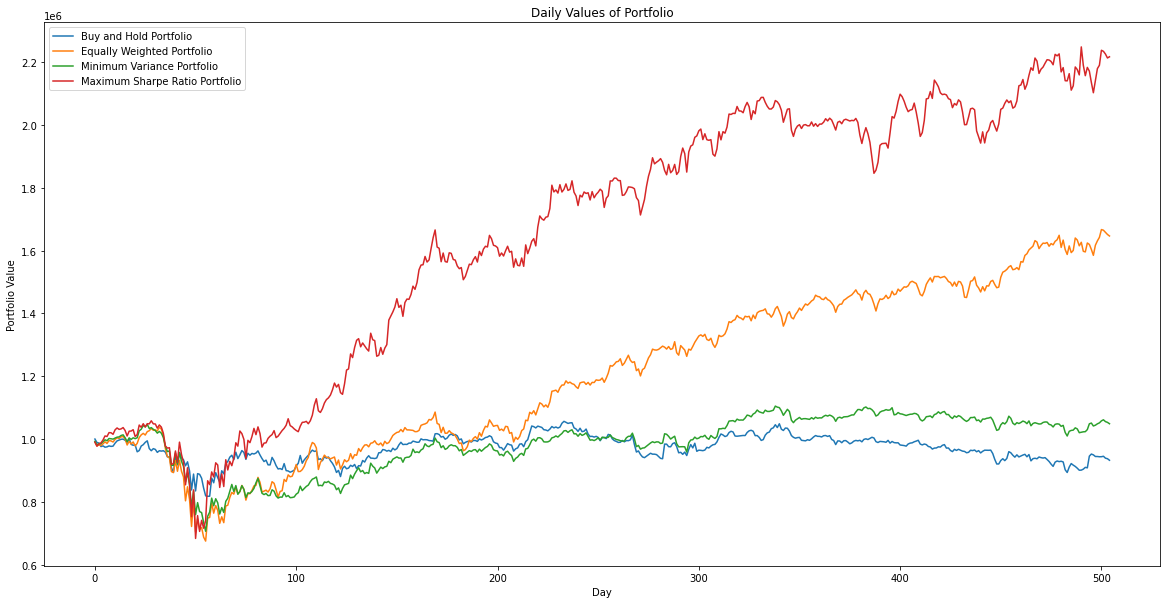

In [235]:
# Plot results
# Daily Values of portfolio
plt.figure(figsize=(20,10))
plt.plot(portf_value[0],label='Buy and Hold Portfolio')
plt.plot(portf_value[1],label='Equally Weighted Portfolio')
plt.plot(portf_value[2],label='Minimum Variance Portfolio')
plt.plot(portf_value[3],label='Maximum Sharpe Ratio Portfolio')
plt.legend()
plt.title('Daily Values of Portfolio')
plt.xlabel('Day')
plt.ylabel('Portfolio Value')
plt.show()



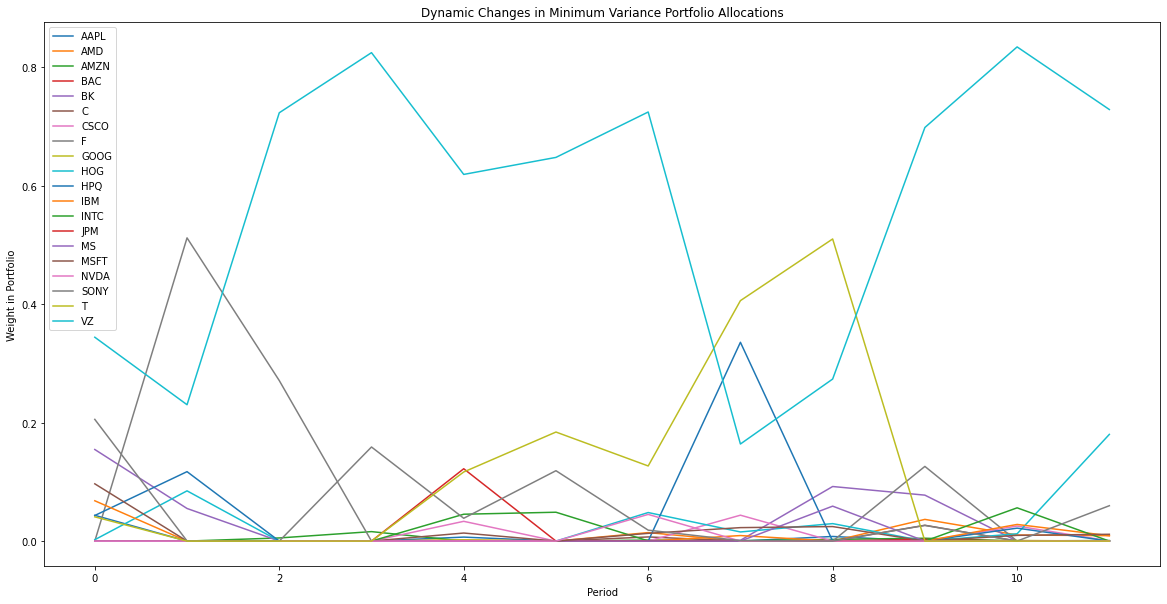

In [236]:
# Dynamic Changes in Minimum Variance Portfolio Allocations
stocks = df.columns[1:]
w = []

for period in range(1, N_periods+1):
    w.append(x[2, period-1]/sum(x[2, period-1]))
    
min_v_df = pd.DataFrame(np.array(w), columns=stocks,)
min_v_df.plot(figsize=(20,10))
plt.title('Dynamic Changes in Minimum Variance Portfolio Allocations')
plt.xlabel('Period')
plt.ylabel('Weight in Portfolio')
plt.show()

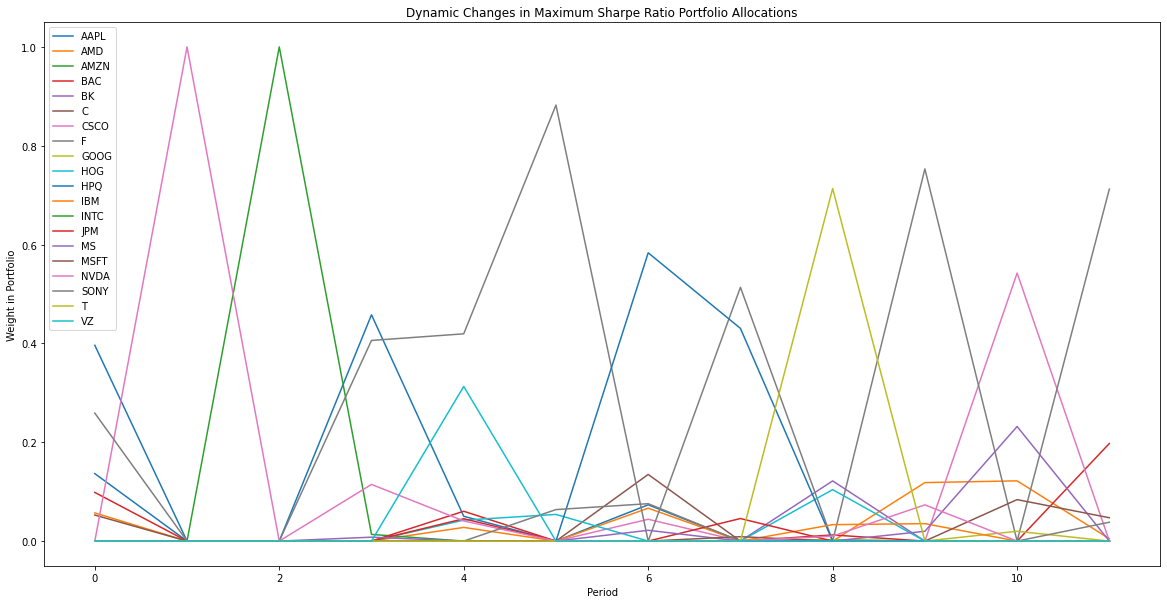

In [237]:
# Dynamic Changes in Maximumm Sharpe Ratio Portfolio Allocations

stocks = df.columns[1:]
w = []

for period in range(1, N_periods+1):
    w.append(x[3, period-1]/sum(x[3, period-1]))
    
max_s_df = pd.DataFrame(np.array(w), columns=stocks,)
max_s_df.plot(figsize=(20,10))
plt.title('Dynamic Changes in Maximum Sharpe Ratio Portfolio Allocations')
plt.xlabel('Period')
plt.ylabel('Weight in Portfolio')
plt.show()

In [239]:
# For possible improvements, we need to know the equally weighted shares in period 1.
x[1,0]

array([ 672., 1011.,   25., 1454., 1034.,  656., 1089., 5237.,   35.,
       1376., 2518.,  424.,  859.,  377., 1006.,  316.,  830.,  720.,
       1492.,  898.])